In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout


In [3]:
# Define a single data generator with augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Training dataset (80% of data)
train_dataset = datagen.flow_from_directory(
    directory= r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset",
    target_size=(300, 300),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation dataset (20% of data)
valid_dataset = datagen.flow_from_directory(
    directory= r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset",
    target_size=(300, 300),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


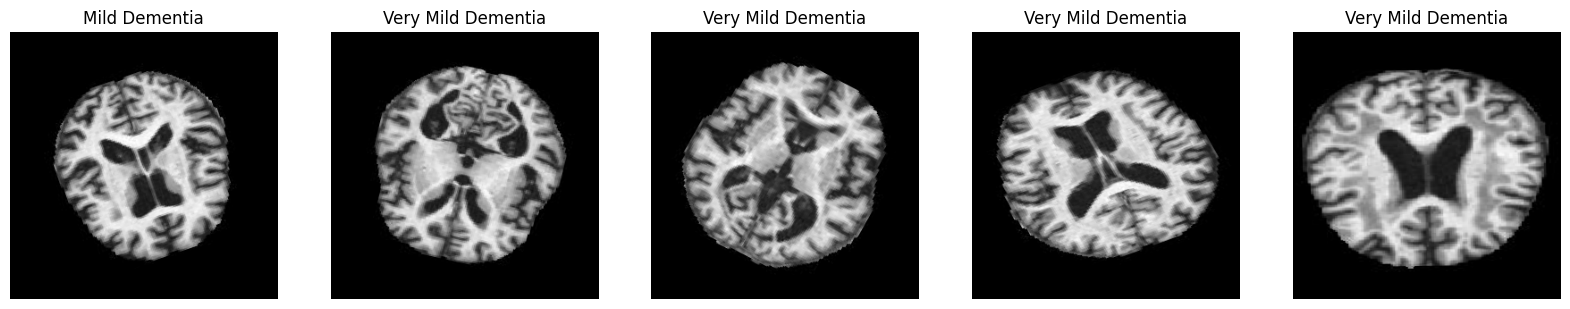

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [5]:
from tensorflow.keras.applications import ResNet152V2
# Load base model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
base_model.trainable = True  # Unfreeze full model for fine-tuning


In [6]:
# Fine-tune only top layers
for layer in base_model.layers[:-40]:
    layer.trainable = False


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
inputs = Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)

In [8]:
# Compile
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 10, 10, 2048)   │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,971,012 (232.59 MB)

 Trainable params: 17,866,244 (68.15 MB)

 Non-trainable params: 43,104,768 (164.43 MB)

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
import tensorflow as tf

OPT = tf.keras.optimizers.Adam(learning_rate=0.001)  # use 'learning_rate', not 'lr'

METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Add custom F1 score only if defined earlier
    # f1_score
]

model.compile(
    loss='categorical_crossentropy',
    optimizer=OPT,
    metrics=METRICS
)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    verbose=1
)

callback_list = [earlystopping]


In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 60,
                        callbacks = callback_list,
                        verbose = 1)

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1993s 49s/step - accuracy: 0.6902 - auc: 0.5977 - loss: 2.0576 - precision: 0.3547 - recall: 0.2906 - val_accuracy: 0.6380 - val_auc: 0.5199 - val_loss: 29.8438 - val_precision: 0.2760 - val_recall: 0.2760
Epoch 2/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 527s 13s/step - accuracy: 0.7508 - auc: 0.7111 - loss: 1.4640 - precision: 0.5022 - recall: 0.3667 - val_accuracy: 0.7584 - val_auc: 0.6801 - val_loss: 20.3061 - val_precision: 0.5169 - val_recall: 0.5137
Epoch 3/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 521s 13s/step - accuracy: 0.7771 - auc: 0.8012 - loss: 1.0815 - precision: 0.5799 - recall: 0.4170 - val_accuracy: 0.7629 - val_auc: 0.7324 - val_loss: 11.6561 - val_precision: 0.5264 - val_recall: 0.5152
Epoch 4/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 530s 13s/step - accuracy: 0.7945 - auc: 0.8313 - loss: 0.9739 - precision: 0.6353 - recall: 0.4181 - val_accuracy: 0.7817 - val_auc: 0.7899 - val_loss: 1.8446 - val_precision: 0.5702 - val_recall: 0.5145
Epoch 5/60
41/41 ━━━━━━━━━━━

In [14]:
model.save('Resnet_alzehimermodel.keras')  

In [29]:
# Average Training Accuracy
avg_train_acc = sum(model_history.history['accuracy']) / len(model_history.history['accuracy'])

# Average Validation Accuracy
avg_val_acc = sum(model_history.history['val_accuracy']) / len(model_history.history['val_accuracy'])

print(f"Average Training Accuracy: {avg_train_acc * 100:.2f}%")
print(f"Average Validation Accuracy: {avg_val_acc * 100:.2f}%")


Average Training Accuracy: 91.25%
Average Validation Accuracy: 85.49%


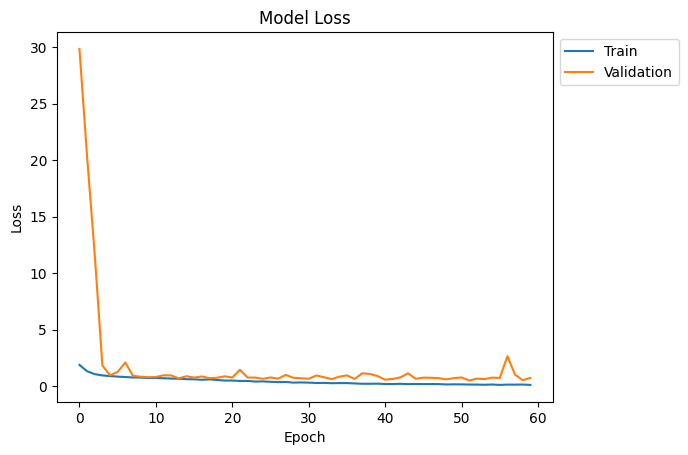

In [15]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

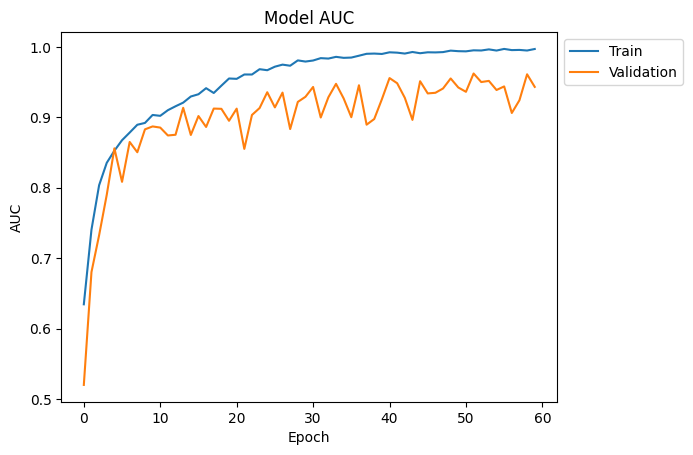

In [16]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
import tensorflow as tf  # Make sure this is at the top

OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Add this only if you've defined it somewhere
    # f1_score,
]

model.compile(
    loss='categorical_crossentropy',
    optimizer=OPT,
    metrics=METRICS
)


In [24]:
# Test Data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset  = test_datagen.flow_from_directory(directory = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset",
                                                 target_size = (300,300),
                                                 class_mode = 'categorical')

Found 6400 images belonging to 4 classes.


In [25]:
model.evaluate(test_dataset)

200/200 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.9138 - auc: 0.9866 - loss: 0.2682 - precision: 0.9161 - recall: 0.9122


[0.28158751130104065,
 0.9857916235923767,
 0.9098437428474426,
 0.912415623664856,
 0.9082812666893005]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


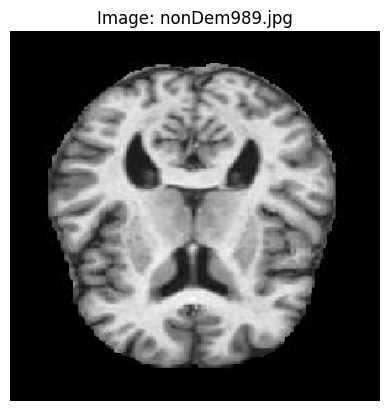

🖼️ Image Name     : nonDem989.jpg
✅ Actual Class   : NonDemented
🔮 Predicted Class: NonDemented
📊 Confidence     : 99.94%


In [33]:
#for Non demented class
from tensorflow.keras.preprocessing.image import load_img, img_to_array
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset\NonDemented\nonDem989.jpg"
actual_class = "NonDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(300, 300, 1))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


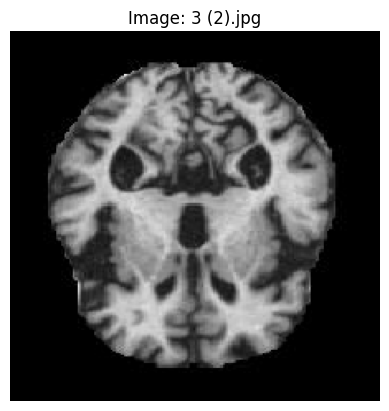

🖼️ Image Name     : 3 (2).jpg
✅ Actual Class   : ModeratedDemented
🔮 Predicted Class: ModerateDemented
📊 Confidence     : 99.98%


In [34]:
# for moderated demented
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset\ModerateDemented\3 (2).jpg"
actual_class = "ModeratedDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


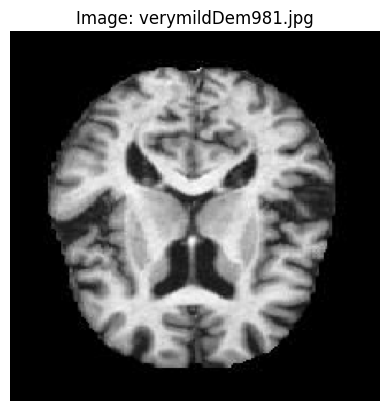

🖼️ Image Name     : verymildDem981.jpg
✅ Actual Class   : veymilddDemented
🔮 Predicted Class: VeryMildDemented
📊 Confidence     : 99.98%


In [35]:
# for very mild demented
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset\VeryMildDemented\verymildDem981.jpg"
actual_class = "veymilddDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")


In [37]:
#Confusion Matrix
model.load_weights('Resnet_alzehimermodel.keras')
true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_dataset)
pred_classes = np.argmax(preds, axis=1)

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


200/200 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step


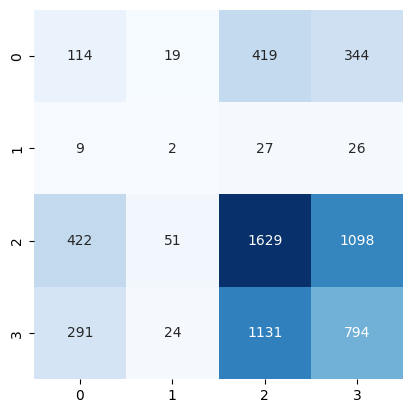

In [38]:
# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, pred_classes)    

plt.show()

In [39]:
model.save('Resnet_alzehimermodel.keras')